# **Solution to PSet 6**

> provided and graded by Andy Chu

[:material-download: Download this notebook](./sol6.ipynb)

In [1]:
# Import required libraries
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from datetime import datetime
from pytz import timezone

# Install and import QuTiP if needed
try:
    from qutip import *
except ImportError:
    %pip install qutip
    from qutip import *

# Configure matplotlib for LaTeX rendering
plt.rcParams.update(
    {
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath} \usepackage{physics}",
        "font.family": "serif",
    }
)
%config InlineBackend.figure_format = 'svg'

# Print version and execution time info
print(f"QuTiP version: {qutip.__version__}")
print(
    "Time of execution: ",
    datetime.now(timezone("America/Chicago")).strftime("%Y-%m-%d %H:%M:%S"),
)

QuTiP version: 5.1.1
Time of execution:  2025-05-01 23:09:30


## **Problem 6-1 [21 points + 2 bonus]**  

Ytterbium nuclear spin qubits

For this problem we will consider the following paper in which the authors realize long-lived nuclear spin qubits with neutral ytterbium atoms in optical tweezers:

- Ma et al. (Thompson group): [*Universal Gate Operations on Nuclear Spin Qubits in an Optical Tweezer Array of* $^{171}\mathrm{Yb}$ *Atoms*](https://doi.org/10.1103/PhysRevX.12.021028), PRX 2022.

We will primarily focus on the single qubit gates and two qubit gates (Figure 2 and 3). There are many details that go into trapping individual ytterbium atoms, that we will not investigate in depth.

### **a. [3 points]**  
In this work, the authors use ytterbium ($^{171}\mathrm{Yb}$) as their atomic species. One motivation behind this is the fact that in the ground state manifold, the two possible spin states are nuclear spin states. What is the reason for not having to consider the electronic spin states? Why is this different from alkali atoms such as rubidium and cesium?

---

In the ${}^1S_0$ ground state of ${}^{171}\mathrm{Yb}$, the total electronic angular momentum $J=0$, so there is no electronic spin degree of freedom.  The remaining two‐level system arises purely from the nuclear spin $I=1/2$.  Alkali atoms ($\mathrm{Rb}$, $\mathrm{Cs}$) have a single valence electron in an $S_{1/2}$ state ($J=1/2$), so their qubit states necessarily involve electronic–nuclear hyperfine eigenstates and are sensitive to differential light shifts and Raman scattering in the trap.

### **b. [3 points]**  
Using the nuclear spin of $^{171}\mathrm{Yb}$ as qubit states has both potential advantages and challenges. Briefly state what in your opinion is the biggest advantage and biggest challenge. Explain the reason behind this advantage and challenge.

---

**Biggest advantage is probably its extreme noise insensitivity.**  

With $J=0$, differential AC-Stark shifts vanish at linear order, and Raman-scattering–induced spin flips are suppressed ($\sim10^{-13}\,\mathrm s^{-1}$), yielding coherence times $T_2^*\!\sim1\,\rm{s}$ and $T_1\sim20\,\rm{s}$.  

**Biggest challenge may be the system's weak control coupling.**  

Nuclear spins couple only via small RF magnetic moments (Larmor $\approx2\pi\times3.09\,\mathrm{kHz}$), so single–qubit Rabi rates are slow ($\Omega_{\rm RF}\approx2\pi\times162\,\mathrm{Hz}$).  Two-qubit gates require precise, narrow-linewidth Rydberg lasers and pulse shaping.


### **c. [3 points]**  
What are the wavelengths used for: Trapping, initialization, readout, single qubit manipulations and two qubit manipulations?

---

-  **Trapping:** optical tweezers at $\lambda=486.78\,\rm{nm}$ (magic for ${}^1S_0\to{}^3P_1$, Fig. 1d).  
-  **Initialization:** optical pumping on ${}^1S_0\to{}^3P_1$ at $\lambda=556\,\rm{nm}$.  
-  **Readout:** two-photon Rydberg blow-out via $556\,\rm{nm}$ + $308\,\rm{nm}$, followed by ${\rm Yb}^+$ autoionization at $369\,\rm{nm}$.  
-  **Single-qubit gates:** RF drive at $\omega_L\approx2\pi\times3.09\,\rm{kHz}$.  
-  **Two-qubit gates:** two-photon Rydberg pulses at $556\,\rm{nm}$ + $308\,\rm{nm}$ with $\Omega_r=2\pi\times0.763\,\rm{MHz}$.


### **d. [3 points]**  
Let’s now turn to the single-qubit manipulations. Use the numbers presented in the text to simulate Figure 3a.

---

We simulate the Ramsey fringes of Fig. 3a by evolving an initial $\pi/2$-rotated state under a small detuning and applying an exponential $T_2^*$ envelope.

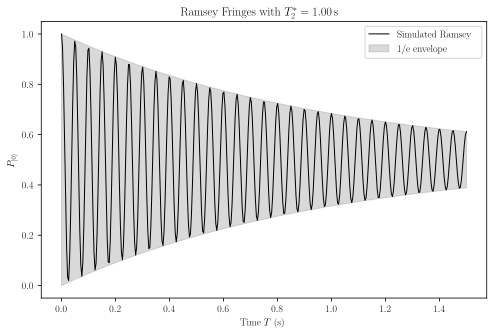

In [2]:
T2_star = 1.00  # s, array-averaged T2*
# delta_freq = 2 * np.pi * 5.0  # Hz, small detuning for visible fringes
delta_freq = 2 * np.pi * 20.0  # Hz, increased frequency to visually match paper ~25 Hz, you can try to tune this but I will not deduct points for your plot being not visually matched to the paper


times = np.linspace(0, 1.5, 400)

P0_coh = 0.5 * (1 + np.cos(delta_freq * times))
P0 = 0.5 * (1 + np.exp(-times / T2_star) * (2 * P0_coh - 1))

plt.figure(figsize=(8, 5))
plt.plot(times, P0, "k-", label="Simulated Ramsey", linewidth=1)
plt.fill_between(
    times,
    0.5 * (1 + np.exp(-times / T2_star)),
    0.5 * (1 - np.exp(-times / T2_star)),
    color="gray",
    alpha=0.3,
    label="1/e envelope",
)
plt.xlabel("Time $T$ (s)")
plt.ylabel("$P_{|0\\rangle}$")
plt.title("Ramsey Fringes with $T_2^*=1.00\\,$s")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()


### **e. [3 points]**  
The authors use randomized benchmarking to characterize their gate fidelities. Explain how this technique can separate out errors caused by state preparation and measurement (SPAM errors) from gate errors. Equation 1 from the paper may be helpful in developing this intuition.

---

Randomized benchmarking fits the average survival probability  

$$
R_S(d) \;=\;\tfrac12 + \tfrac12(1-2\epsilon_{\rm spam})(1-2\epsilon_{\rm gate})^d
$$  

as a function of sequence depth $d$.  SPAM errors, $\epsilon_{\rm spam}$, only affect the baseline and prefactor (independent of $d$), while gate errors, $\epsilon_{\rm gate}$, cause the exponential decay with $d$.  A two-parameter fit cleanly separates SPAM from gate infidelity.

### **f. [3 points]**  
What are the main limitations of the coherence time?

---

The main coherence limits are:  

-  **Magnetic field drifts & gradients**, causing inhomogeneous dephasing (visible as chirp/envelope in Fig. 3a).  
-  **Technical noise** in the bias‐coil current source, leading to slow phase fluctuations (affects echo).  
-  **Leaked resonant light**, giving residual Raman scattering and finite $T_1\sim20\,\rm{s}$.

### **g. [3 points]**  
The two qubit gate presented here is similar to the one you investigated for the last Pset. One difference is that the drives are applied at finite detuning. The underlying principle is still the same in that the states $\ket{01}$ and $\ket{10}$ enclosed a different area on the Bloch sphere as compared to $\ket{11}$ (see also figure 4b and c). Verify that for $\Delta/\Omega_r \approx 0.377$, $\xi \approx 3.902$ and $\tau \Omega_r \approx 4.293$ this indeed realizes a CZ gate (up to single qubit gates).

---

To verify $\phi_{11}=2\phi_{01}+\pi$ for $\Delta/\Omega_r=0.377$, $\tau\Omega_r=4.293$, $\xi=3.902$, we still use the code from last PSet but now introduce the detuning for the Rydberg pulse. In Harry Levine's notation [PRL 123, 170503 (2019)], we have

$$
\hat H = \sum_{i = 1,2} \frac{|\Omega|}{2} \bigg(e^{i\xi}|1\rangle_i \langle r| + e^{-i\xi}|r\rangle_i \langle 1| - \Delta |r\rangle_i \langle r|\bigg) + V|r,r\rangle\langle r,r|.
$$

So in the $\begin{pmatrix} |0,1\rangle \\ |0,r\rangle \end{pmatrix}$ subspace, the Hamiltonian should be $\begin{pmatrix} 0 & \Omega/2 \\ \Omega^*/2 & -\Delta \end{pmatrix}$; 

while in $\begin{pmatrix} |1,1\rangle \\ |W\rangle \end{pmatrix}$ subspace, the Hamiltonian should be $\begin{pmatrix} 0 & \sqrt{2}\Omega/2 \\ \sqrt{2}\Omega^*/2 & -\Delta \end{pmatrix}$.

**Note**: You may achieve unwanted result if you choose diagonal part as $\begin{pmatrix} \Delta/2 & 0 \\ 0 & -\Delta/2 \end{pmatrix}$.

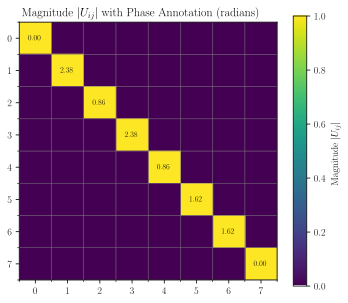

phi_01 = 2.380762 rad
phi_10 = 2.380762 rad
phi_11 = 1.619934 rad
phi_11 - (phi_01 + phi_10) mod 2π = 3.141595 rad (should be close to π)


In [ ]:
# Define the Hamiltonian for the 8-level system
def H(Omega, xi, Delta):
    Omega_cplx = Omega * np.exp(1j * xi)
    # Coupling terms
    H1 = Omega_cplx * (
        basis(8, 1) * basis(8, 2).dag()
        + basis(8, 3) * basis(8, 4).dag()
        + np.sqrt(2) * basis(8, 5) * basis(8, 6).dag()
    )
    # Detuning terms
    H_dtng = -Delta * (ket2dm(basis(8, 2)) + ket2dm(basis(8, 4)) + ket2dm(basis(8, 6)))
    H_total = (H1 + H1.dag()) / 2 + H_dtng
    return H_total


def U_rot(Omega, xi, Delta, tau):
    return (-1j * H(Omega, xi, Delta) * tau).expm()


Omega = 1.0
Delta = 0.377371 * Omega
xi = 3.90242
tau = 4.29268 / Omega

# Unitary operator for 2 rotations sequentially with xi phase difference
U = U_rot(Omega, xi, Delta, tau) * U_rot(Omega, 0, Delta, tau)

# Visualize the magnitude and phase of the unitary matrix U
U_np = U.full()
mag = np.abs(U_np)
phase = np.angle(U_np)

fig, ax = plt.subplots(1, 1, figsize=(5, 5)) 

im_mag = ax.matshow(mag, cmap="viridis", vmin=0, vmax=1)
fig.colorbar(im_mag, ax=ax, shrink=0.8, label="Magnitude $|U_{ij}|$")
ax.set_title("Magnitude $|U_{ij}|$ with Phase Annotation (radians)")
ax.xaxis.set_ticks_position("bottom")

for i in range(mag.shape[0]):
    for j in range(mag.shape[1]):
        text_color = "white" if mag[i, j] < 0.5 else "black"
        if mag[i, j] > 1e-3:
            ax.text(
                j,
                i,
                f"{phase[i, j]:.2f}",
                ha="center",
                va="center",
                color=text_color,
                fontsize=8,
            )

ax.set_xticks(np.arange(8))
ax.set_yticks(np.arange(8))
ax.set_xticks(np.arange(-0.5, 8, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 8, 1), minor=True)
ax.grid(which="minor", color="grey", linestyle="-", linewidth=0.5)
plt.tight_layout()
plt.show()

# Extract phases for |01⟩, |10⟩, |11⟩
phi_01 = np.angle(U.full()[1, 1])
phi_10 = np.angle(U.full()[3, 3])
phi_11 = np.angle(U.full()[5, 5])

# Check CZ condition
phase_check = (phi_11 - (phi_01 + phi_10)) % (2 * np.pi)
print(f"phi_01 = {phi_01:.6f} rad")
print(f"phi_10 = {phi_10:.6f} rad")
print(f"phi_11 = {phi_11:.6f} rad")
print(
    f"phi_11 - (phi_01 + phi_10) mod 2π = {phase_check:.6f} rad (should be close to π)"
)

### **h. [Bonus - 2 points]**  
Recreate the trajectories for the different qubit states on the Bloch sphere (figure 4b).

---

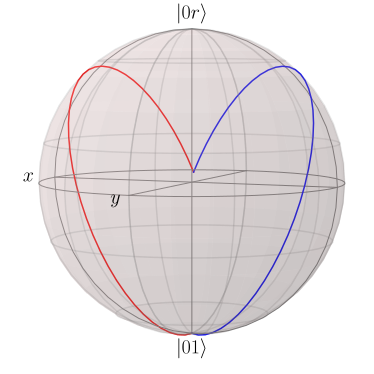

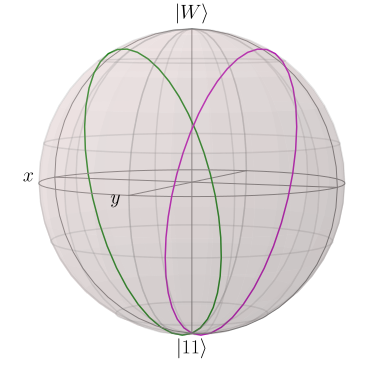

In [6]:
# For |01⟩ and |0r⟩ subspace (first qubit in |0⟩, second qubit in |1⟩/|r⟩)
sigax = basis(8, 1) * basis(8, 2).dag() + basis(8, 2) * basis(8, 1).dag()
sigay = 1j * basis(8, 1) * basis(8, 2).dag() - 1j * basis(8, 2) * basis(8, 1).dag()
sigaz = basis(8, 2) * basis(8, 2).dag() - basis(8, 1) * basis(8, 1).dag()

# For |11⟩ and |W⟩ subspace (both qubits in |1⟩ or entangled Rydberg state)
sigbx = basis(8, 5) * basis(8, 6).dag() + basis(8, 6) * basis(8, 5).dag()
sigby = 1j * basis(8, 5) * basis(8, 6).dag() - 1j * basis(8, 6) * basis(8, 5).dag()
sigbz = basis(8, 6) * basis(8, 6).dag() - basis(8, 5) * basis(8, 5).dag()

psi_01 = basis(8, 1)  # |01⟩ state
psi_11 = basis(8, 5)  # |11⟩ state
n_points = 40
time_points = np.linspace(0, 1, n_points)

# First pulse (phase=0)
psi_01_p1 = [U_rot(Omega, 0, Delta, tau * eta) * psi_01 for eta in time_points]
psi_11_p1 = [U_rot(Omega, 0, Delta, tau * eta) * psi_11 for eta in time_points]

# Second pulse (phase=xi)
psi_01_p2 = [U_rot(Omega, xi, Delta, tau * eta) * psi_01_p1[-1] for eta in time_points]
psi_11_p2 = [U_rot(Omega, xi, Delta, tau * eta) * psi_11_p1[-1] for eta in time_points]


# --- Bloch sphere for |01⟩ trajectory ---
b_01 = Bloch()
b_01.add_points(
    [
        [expect(sigax, state) for state in psi_01_p1],
        [expect(sigay, state) for state in psi_01_p1],
        [expect(sigaz, state) for state in psi_01_p1],
    ],
    "l",
)
b_01.add_points(
    [
        [expect(sigax, state) for state in psi_01_p2],
        [expect(sigay, state) for state in psi_01_p2],
        [expect(sigaz, state) for state in psi_01_p2],
    ],
    "l",
)

b_01.point_color = ["r", "b"]
b_01.zlabel = [r"$|0r\rangle$", r"$|01\rangle$"]
b_01.zlpos = [1.1, -1.1]
b_01.view = (90 / 4, 5)
b_01.title = r"Trajectory for $\ket{01}$ state"
b_01.render()
b_01.show()

# --- Bloch sphere for |11⟩ trajectory ---
b_11 = Bloch()

b_11.add_points(
    [
        [expect(sigbx, state) for state in psi_11_p1],
        [expect(sigby, state) for state in psi_11_p1],
        [expect(sigbz, state) for state in psi_11_p1],
    ],
    "l",
)
b_11.add_points(
    [
        [expect(sigbx, state) for state in psi_11_p2],
        [expect(sigby, state) for state in psi_11_p2],
        [expect(sigbz, state) for state in psi_11_p2],
    ],
    "l",
)

b_11.point_color = ["g", "m"]
b_11.zlabel = [r"$|W\rangle$", r"$|11\rangle$"]
b_11.zlpos = [1.1, -1.1]
b_11.view = (90 / 4, 5)
b_11.title = r"Trajectory for $\ket{11}$ state"
b_11.render()
b_11.show()

## **Problem 6-2 [15 points]**  

High-fidelity trapped ion gates

- Ballance et al. (Lucas group): [*High-Fidelity Quantum Logic Gates Using Trapped-Ion Hyperfine Qubits*](https://doi.org/10.1103/PhysRevLett.117.060504), PRL 2016

Ballance et al. demonstrate in their paper a high-fidelity implementation of the geometric phase gate, as well as high-fidelity single qubit gates.

### **a. [3 points]**  
The authors use different hyperfine states for the demonstration of high-fidelity single qubit gates and high-fidelity 2-qubit gates. Why do they choose these states?

---

- The qubit for two-qubit gates, encoded in $(S_{1/2}^{4,+4} - S_{1/2}^{3,+3})$, is used as the 'gate' qubit. It can be prepared and read out with high fidelity by optical pumping (since both hyperfine states are at the highest Zeeman levels), and is highly magnetically sensitive (2.45kHz/mG), which is necessary for producing a differential light-shift between the qubit states in the light-shift gate scheme.

- The qubit encoded in $(S_{1/2}^{4,0} - S_{1/2}^{3,0})$ is used as the 'memory' qubit. It is harder to prepare and read out, but much less magnetically sensitive (4.8 Hz/mG for $B_0 = 2 G$), allowing randomized benchmarking of laser driven single-qubit gates to be used (which is necessary to render the gate error observable above the state preparation and measurement errors).

- One can show that for the clock 'memory' states the differential light-shift tends to zero for large Raman detunings ($|\Delta| \gg \omega_{\rm HF}$) which is required to suppress photon scattering. This means that, in practice, one cannot use this light-shift gate on 'memory' qubits - a magnetically sensitive qubit transition is required.

- They have demonstrated mapping between the 'gate' qubit and the 'memory' qubit with errors $\approx 2 \times 10^{-4}$. Thus they could map two ions out of the clock 'memory' qubit, perform an entangling gate, and map back into the 'memory' qubit with an error below $10^{-3}$ with current experimental techniques.

### **b. [3 points]**  
Why do the authors place the ions at a distance of 12.5 wavelengths in the standing wave along the trap axis?

---

Because when the ion spacing is a half-integer number of standing wave periods, the two ions experience opposite optical phases. If they are in same spin states, the forces on them are in opposite directions. So the excitation of the center-of-mass (COM) mode is minimal.

- The authors utilize the center-of-mass (COM) motional normal mode instead of the stretch mode by using Raman difference frequency $\delta = f_z + \delta_g$ close to the frequency of the COM mode.
- If the two ions are in $|\uparrow\uparrow\rangle$ or $|\downarrow\downarrow\rangle$ state, there, because they experience opposite optical phase, they experience opposite but equal forces so that the COM mode is NOT excited. That is, $|\uparrow\uparrow\rangle \to |\uparrow\uparrow\rangle$, $|\downarrow\downarrow\rangle \to |\downarrow\downarrow\rangle$.
- If they are in $|\uparrow\downarrow\rangle$ or $|\downarrow\uparrow\rangle$, then because of the different AC Stark shifts, they experience different forces, so that the COM mode is excited. The periodic near-resonant force effectively acts as a displacement Hamiltonian. When $\tau = 1/\delta_g$, the motion of ions return to the initial point in the phase space (though in opposite directions for $|\uparrow\downarrow\rangle$ and $|\downarrow\uparrow\rangle$), but accumulates a phase. However, the accumulated geometric phase is determined by the area circled by the trajectories in the phase space. So they acquire a same phase $\varphi$. That is $|\uparrow\downarrow\rangle \to e^{i\varphi}|\uparrow\downarrow\rangle$, $|\downarrow\uparrow\rangle \to e^{i\varphi}|\downarrow\uparrow\rangle$.
- One can see $|\downarrow\downarrow\rangle \to |\downarrow\downarrow\rangle$ as $|\downarrow\downarrow\rangle \to e^{-2i\varphi}e^{2i\varphi}|\downarrow\downarrow\rangle$.
- In this way they realize a gate that resembles $\sigma_z \otimes \sigma_z$, up to a single-qubit $\varphi$-phase gate.
- If the ion spacing is an integer number of standing wave periods, the COM mode will be excited when the ions are in $|\uparrow\uparrow\rangle$ or $|\downarrow\downarrow\rangle$ state. Then the gate cannot operate as desired.

### **c. [3 points]**  
What are SPAM errors and why is it justified to correct for them in Figure 3a? In a full quantum algorithm, would these errors matter?

---

- SPAM-error means State Preparation and Measurement Error.

- In figure 3(a), Single-qubit SPAM errors (together with spin-echo errors) have been subtracted from the data since we only want to evaluate the two-qubit gate errors. The most important feature of SPAM errors (and spin-echo error) which justify our subtraction is that neither of them do not vary with the number of gates. Thus we simply normalize the same value ($\epsilon_{\rm SPAM} \approx 1.7 \times 10^{-3}$ per qubit) together with the total number of qubits for our calculation.

    These errors matter because the average operation time of the algorithms will be extended, and more qubits will have to be used due to the error.

### **d. [3 points]**  
In Figure 3a, the authors identify two different error regimes for short and long gate times. Please describe these regimes and what limits the gate fidelity in each of them.

---


**Short gate time errors:**

- **Off-resonant error:** Fidelity limited by the frequency spread of the Raman laser.
- **Photon scattering error:** Fidelity limited by beam intensity for both Raman and Rayleigh scattering processes.

**Long gate time errors:**

- **Motional error:** Fidelity limited by non-zero temperature of the ions, ambient heating, and dephasing of the motional mode during gate operation.
- **Spin dephasing error:** Fidelity limited by magnetic field fluctuations.

### **e. [3 points]**  
If you could change one piece of equipment in this experiment in order to improve the gate fidelity, which one would you choose?

---

There are a variety of aspects that you can improve. For instance, you can choose the Raman lasers. Since in Table I, Raman photon scattering is the major error source. If we can increase the intensity (and detuning), the scattering error can be lower.

Another good point would be magnetic field control, as spin dephasing due to magnetic field fluctuations is another significant error source, especially for longer gate times.